In [1]:
import re, string
import nltk
import zipfile
import os
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, multiply, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score,  precision_recall_fscore_support, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
import nlpaug.augmenter.word as naw
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import seaborn as sns

In [97]:
non_trojan_path = 'New_Trojanfree/'
trojan_path = 'New_Trojan/'

In [ ]:
lines = [line.strip() for line in file if not line.startswith(('.', '_'))]

In [98]:
def read_file_first_word(file_path, line_flag):
    opcodes_list = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading and trailing whitespaces
            if line and not line.startswith('";') and ';' not in line and "file" not in line:  # Ignore empty lines and lines starting with '"; for removal of comments' 
                if line_flag == 0:
                    words = line.split(' ')
                    first_word = words[0].strip()
                    if first_word:
                        opcodes_list.append(first_word)
                else:
                    # print(line)
                    if line:
                        opcodes_list.append(line)
                    
    str_input = ' '.join([str(elem) for elem in opcodes_list])
    return str_input

In [895]:
str_input = []
# if line_flag = 0, functions takes the first word(opcode)
# if line_flag = 1, fuctions takes the opcode and operators as well.
line_flag = 1
aug_swap = naw.random.RandomWordAug(action='swap', aug_p=0.2) # swap data randomly
aug_delete = naw.random.RandomWordAug(action='delete', aug_p=0.2)
# Non-Trojan 0
# Trojan 0
# Desktop/Trojan/hw2vec/Non-Trojan/AES-T100_table_asm.txt
df = pd.DataFrame(columns = ['Text', 'Label'])

for path in os.listdir(non_trojan_path):
    path_full = non_trojan_path + "/" + path
    
    if path != '.ipynb_checkpoints':
        label = 0
        str_input = read_file_first_word(path_full, line_flag)
        
        swapped_data = aug_swap.augment(str_input, n=5)
        # print(len(swapped_data))
        deleted_data = aug_delete.augment(str_input, n=5)
        
        df.loc[len(df)] = [str_input, label]
        
        for item in swapped_data:
            df.loc[len(df)] = [item, label]
        for item in deleted_data:
            df.loc[len(df)] = [item, label]
    
for path in os.listdir(trojan_path):
    path_full = trojan_path + '/' + path
    
    if path != '.ipynb_checkpoints':
        label = 1
        str_input = read_file_first_word(path_full, line_flag)
        
        swapped_data_trojan = aug_swap.augment(str_input, n=4)
        deleted_data_trojan = aug_delete.augment(str_input, n=4)
        
        df.loc[len(df)] = [str_input, label]
        
        for item in swapped_data_trojan:
            df.loc[len(df)] = [item, label]
        for item in deleted_data_trojan:
            df.loc[len(df)] = [item, label]
    

In [663]:
df.to_pickle("test_new.pkl")

In [5]:
import pickle

In [6]:
file = "test_new.pkl"

In [7]:
with open(file, 'rb') as f: 
    my_list = pickle.load(f)

In [8]:
df = my_list

# DATA IMBALANCE CREATION

# END IMBALANCE

# PERFORMANCE METRICS FUNCTION

In [9]:
def print_performance_metrics(cm):
    tn, fp, fn, tp = cm.ravel()

    # Calculaabste True Positive Rate (TPR), False Positive Rate (FPR), Accuracy, Precision, Recall, and F1 score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate Specificity (True Negative Rate, TNR)
    tnr = tn / (tn + fp)

    # Calculate Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    # Calculate Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    # Print the results
    print("Confusion Matrix:")
    print(cm)
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print("True Positive Rate (TPR):", tpr)
    print("False Positive Rate (FPR):", fpr)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Specificity (TNR):", tnr)
    print("Negative Predictive Value (NPV):", npv)
    print("Positive Predictive Value (PPV):", ppv)
    print("Matthews Correlation Coefficient (MCC):", mcc)
            
    # Create a bar plot to visualize TP, FP, TN, FN
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    values = [tn, fp, fn, tp]

    # plt.figure(figsize=(8, 6))
    # plt.bar(labels, values, color=['green', 'red', 'orange', 'blue'])
    # plt.xlabel('Confusion Matrix Elements')
    # plt.ylabel('Counts')
    # plt.title('Confusion Matrix')
    # plt.show()

# CONFUSION MATRIX

In [10]:
def create_conf_matrix(cf_matrix):
    sns.set(font_scale=1)
    plt.rcParams.update({'font.size': 14})
    plt.rcParams['font.family'] = 'Consolas'

    # Assuming you have defined cf_matrix

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Create the heatmap with custom font and bold text
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontweight": "bold", "fontsize": 12})

    plt.show()

# DATASET CREATION

In [916]:
df = df.sample(frac=1)

In [917]:
df["Label"].value_counts()

Label
1    270
0    220
Name: count, dtype: int64

In [918]:
X_train, X_test, y_train, y_test = train_test_split(df["Text"],df["Label"],test_size=0.15, shuffle=True, random_state = 42)

In [919]:
y_test.value_counts()

Label
0    37
1    37
Name: count, dtype: int64

In [920]:
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train, y_train,stratify=y_train, test_size=0.15, random_state=42) # 0.1 x 0.8

In [921]:
len(X_train_dl)

353

In [922]:
len(X_test)

74

In [923]:
len(y_val_dl)

63

In [924]:
y_val_dl.value_counts()

Label
1    35
0    28
Name: count, dtype: int64

In [925]:
print(type(X_train))

<class 'pandas.core.series.Series'>


# TFIDF for SVM

In [926]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df["Text"])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [927]:
Test_X_Tfidf.shape

(74, 460)

# SVM

In [928]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  64.86486486486487


In [929]:
y_test.value_counts()

Label
0    37
1    37
Name: count, dtype: int64

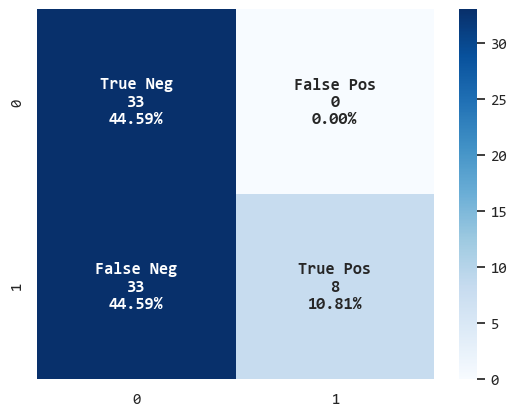

Confusion Matrix:
[[33  0]
 [33  8]]
True Positives (TP): 8
False Positives (FP): 0
True Negatives (TN): 33
False Negatives (FN): 33
True Positive Rate (TPR): 0.1951219512195122
False Positive Rate (FPR): 0.0
Accuracy: 0.5540540540540541
Precision: 1.0
Recall: 0.1951219512195122
F1 Score: 0.326530612244898
Specificity (TNR): 1.0
Negative Predictive Value (NPV): 0.5
Positive Predictive Value (PPV): 1.0
Matthews Correlation Coefficient (MCC): 0.31234752377721214


In [910]:
cf_matrix_svm = confusion_matrix(y_test, predictions_SVM)
create_conf_matrix(cf_matrix_svm)
print_performance_metrics(cf_matrix_svm)

In [613]:
len(y_test)

59

# NB 

In [930]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
X_test_counts = count_vect.fit_transform(X_test)
X_test_counts.shape


(74, 458)

In [931]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf_nb = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf_nb.shape
X_test_tfidf_nb = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf_nb.shape

(74, 458)

In [932]:
clf = MultinomialNB().fit(X_train_tfidf_nb, y_train)


text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
 ])

text_clf = text_clf.fit(X_train, y_train)

predicted_nb = text_clf.predict(X_test)
np.mean(predicted_nb == y_test)

0.5

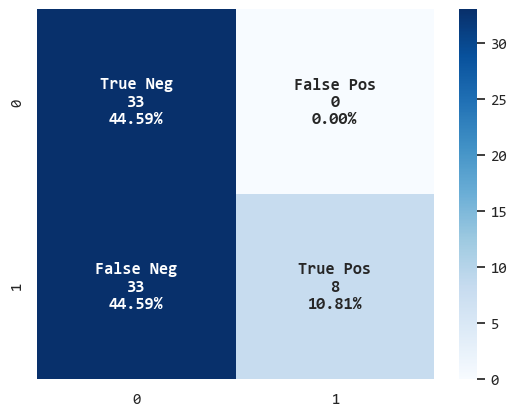

Confusion Matrix:
[[33  0]
 [33  8]]
True Positives (TP): 8
False Positives (FP): 0
True Negatives (TN): 33
False Negatives (FN): 33
True Positive Rate (TPR): 0.1951219512195122
False Positive Rate (FPR): 0.0
Accuracy: 0.5540540540540541
Precision: 1.0
Recall: 0.1951219512195122
F1 Score: 0.326530612244898
Specificity (TNR): 1.0
Negative Predictive Value (NPV): 0.5
Positive Predictive Value (PPV): 1.0
Matthews Correlation Coefficient (MCC): 0.31234752377721214


In [933]:
cf_matrix_nb = confusion_matrix(y_test, predicted_nb)
create_conf_matrix(cf_matrix_svm)
print_performance_metrics(cf_matrix_svm)

In [915]:
y_test.value_counts()

Label
1    41
0    33
Name: count, dtype: int64

# Logistic Regression

In [ ]:
F1_score = metrics.f1_score(y_test, predictions)

In [ ]:
F1_score

In [ ]:
test_df = pd.DataFrame()

In [ ]:
total_docs = X_train + X_test

# Tokenization and Embedding for CNN

In [763]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(df['Text'])

In [764]:
X_train_list = X_train_dl.tolist()
X_test_list = X_test.tolist()
X_val_list = X_val_dl.tolist()

In [765]:
X_train_dl

75     . intel_syntax noprefix. text. section. rodata...
206    . intel_syntax noprefix. text. section. rodata...
242    . intel_syntax noprefix. text. section. rodata...
41     . intel_syntax noprefix. text. section. rodata...
420    . intel_syntax noprefix. text. section. rodata...
                             ...                        
29     . intel_syntax noprefix. text. section. rodata...
130    . intel_syntax noprefix. text. section. rodata...
32     . intel_syntax noprefix. text. section. rodata...
127    . intel_syntax noprefix. text. section. rodata...
180    . intel_syntax noprefix. text. section. rodata...
Name: Text, Length: 353, dtype: object

In [766]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_list)
X_val_tokenized = tokenizer.texts_to_sequences(X_val_list)

In [767]:
max_length = max([len(s.split()) for s in df.Text])

In [768]:
X_train_token_pad = pad_sequences(X_train_tokenized, maxlen=max_length, padding='post')
X_test_token_pad = pad_sequences(X_test_tokenized, maxlen=max_length, padding='post')
X_val_token_pad = pad_sequences(X_val_tokenized, maxlen=max_length, padding='post')

In [769]:
max_length

5389

In [770]:
vocab_size = len(tokenizer.word_index) + 1

In [771]:
vocab_size

513

# CNN MODEL DEFINITION

In [772]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf

In [773]:
len(X_train_token_pad)

353

In [774]:
len(X_test_token_pad)

74

In [876]:
from keras import backend as K 

# Do some code, e.g. train and save model

tf.keras.backend.clear_session()

In [877]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 48, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.15))  # Add Dropout layer with 50% dropout rate
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5389, 48)          24624     
                                                                 
 conv1d (Conv1D)             (None, 5382, 32)          12320     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2691, 32)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 2691, 32)          128       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 86112)             0         
                                                                 
 dense (Dense)               (None, 10)                8

Epoch 1/10
12/12 - 7s - loss: 1.0385 - accuracy: 0.8159 - val_loss: 0.4799 - val_accuracy: 0.8919 - lr: 0.0010 - 7s/epoch - 556ms/step
Epoch 2/10
12/12 - 6s - loss: 0.2301 - accuracy: 0.8895 - val_loss: 0.4114 - val_accuracy: 0.9054 - lr: 0.0010 - 6s/epoch - 484ms/step
Epoch 3/10
12/12 - 7s - loss: 0.1809 - accuracy: 0.9037 - val_loss: 0.3655 - val_accuracy: 0.9054 - lr: 0.0010 - 7s/epoch - 547ms/step
Epoch 4/10
12/12 - 6s - loss: 0.1690 - accuracy: 0.9093 - val_loss: 0.3486 - val_accuracy: 0.9054 - lr: 0.0010 - 6s/epoch - 537ms/step
Epoch 5/10
12/12 - 6s - loss: 0.1826 - accuracy: 0.9093 - val_loss: 0.3357 - val_accuracy: 0.9054 - lr: 0.0010 - 6s/epoch - 469ms/step
Epoch 6/10
12/12 - 6s - loss: 0.1541 - accuracy: 0.9093 - val_loss: 0.3350 - val_accuracy: 0.9054 - lr: 0.0010 - 6s/epoch - 494ms/step
Epoch 7/10
12/12 - 7s - loss: 0.1536 - accuracy: 0.9093 - val_loss: 0.3272 - val_accuracy: 0.8919 - lr: 0.0010 - 7s/epoch - 569ms/step
Epoch 8/10
12/12 - 7s - loss: 0.1551 - accuracy: 0.9093

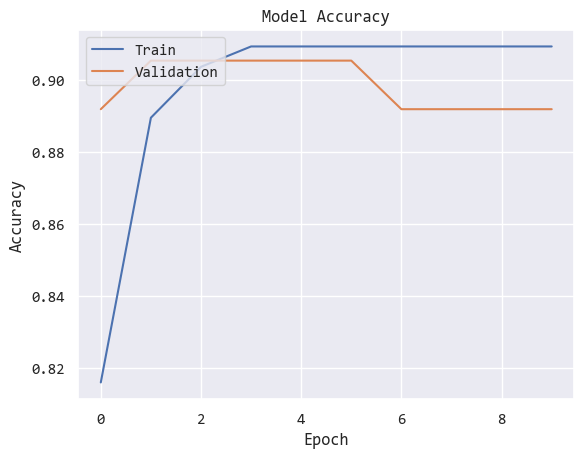

In [878]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
N_epochs = 10
# compile network with Adam optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# fit network with callbacks
history = model.fit(X_train_token_pad, y_train_dl, epochs=N_epochs, verbose=2,
                    validation_data=(X_test_token_pad, y_test),
                    callbacks=[early_stopping, reduce_lr])

# evaluate on validation set
loss, acc = model.evaluate(X_val_token_pad, y_val_dl, verbose=0)
print('Validation Accuracy: {:.2f}%'.format(acc * 100))

# plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [879]:
loss, test_acc = model.evaluate(X_val_token_pad, y_val_dl, verbose=0)
print('Test Accuracy: {:.2f}%'.format(test_acc * 100))

Test Accuracy: 93.65%


In [880]:
print('Test Accuracy: %f' % (test_acc*100))

Test Accuracy: 93.650794


In [881]:
# Calculate predicted probabilities for the validation data
y_pred_prob = model.predict(X_val_token_pad)

# Convert predicted probabilities into binary predictions (0 or 1)
y_pred = np.round(y_pred_prob).astype(int).flatten()

# Create a confusion matrix
cm_cnn = confusion_matrix(y_val_dl, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm_cnn)


2/2 [==============================] - 0s 141ms/step
Confusion Matrix:
[[25  4]
 [ 0 34]]


In [882]:
print_performance_metrics(cm_cnn)

Confusion Matrix:
[[25  4]
 [ 0 34]]
True Positives (TP): 34
False Positives (FP): 4
True Negatives (TN): 25
False Negatives (FN): 0
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.13793103448275862
Accuracy: 0.9365079365079365
Precision: 0.8947368421052632
Recall: 1.0
F1 Score: 0.9444444444444444
Specificity (TNR): 0.8620689655172413
Negative Predictive Value (NPV): 1.0
Positive Predictive Value (PPV): 0.8947368421052632
Matthews Correlation Coefficient (MCC): 0.878251025552403


In [863]:
epochs = [x for x in range(1, 11)]

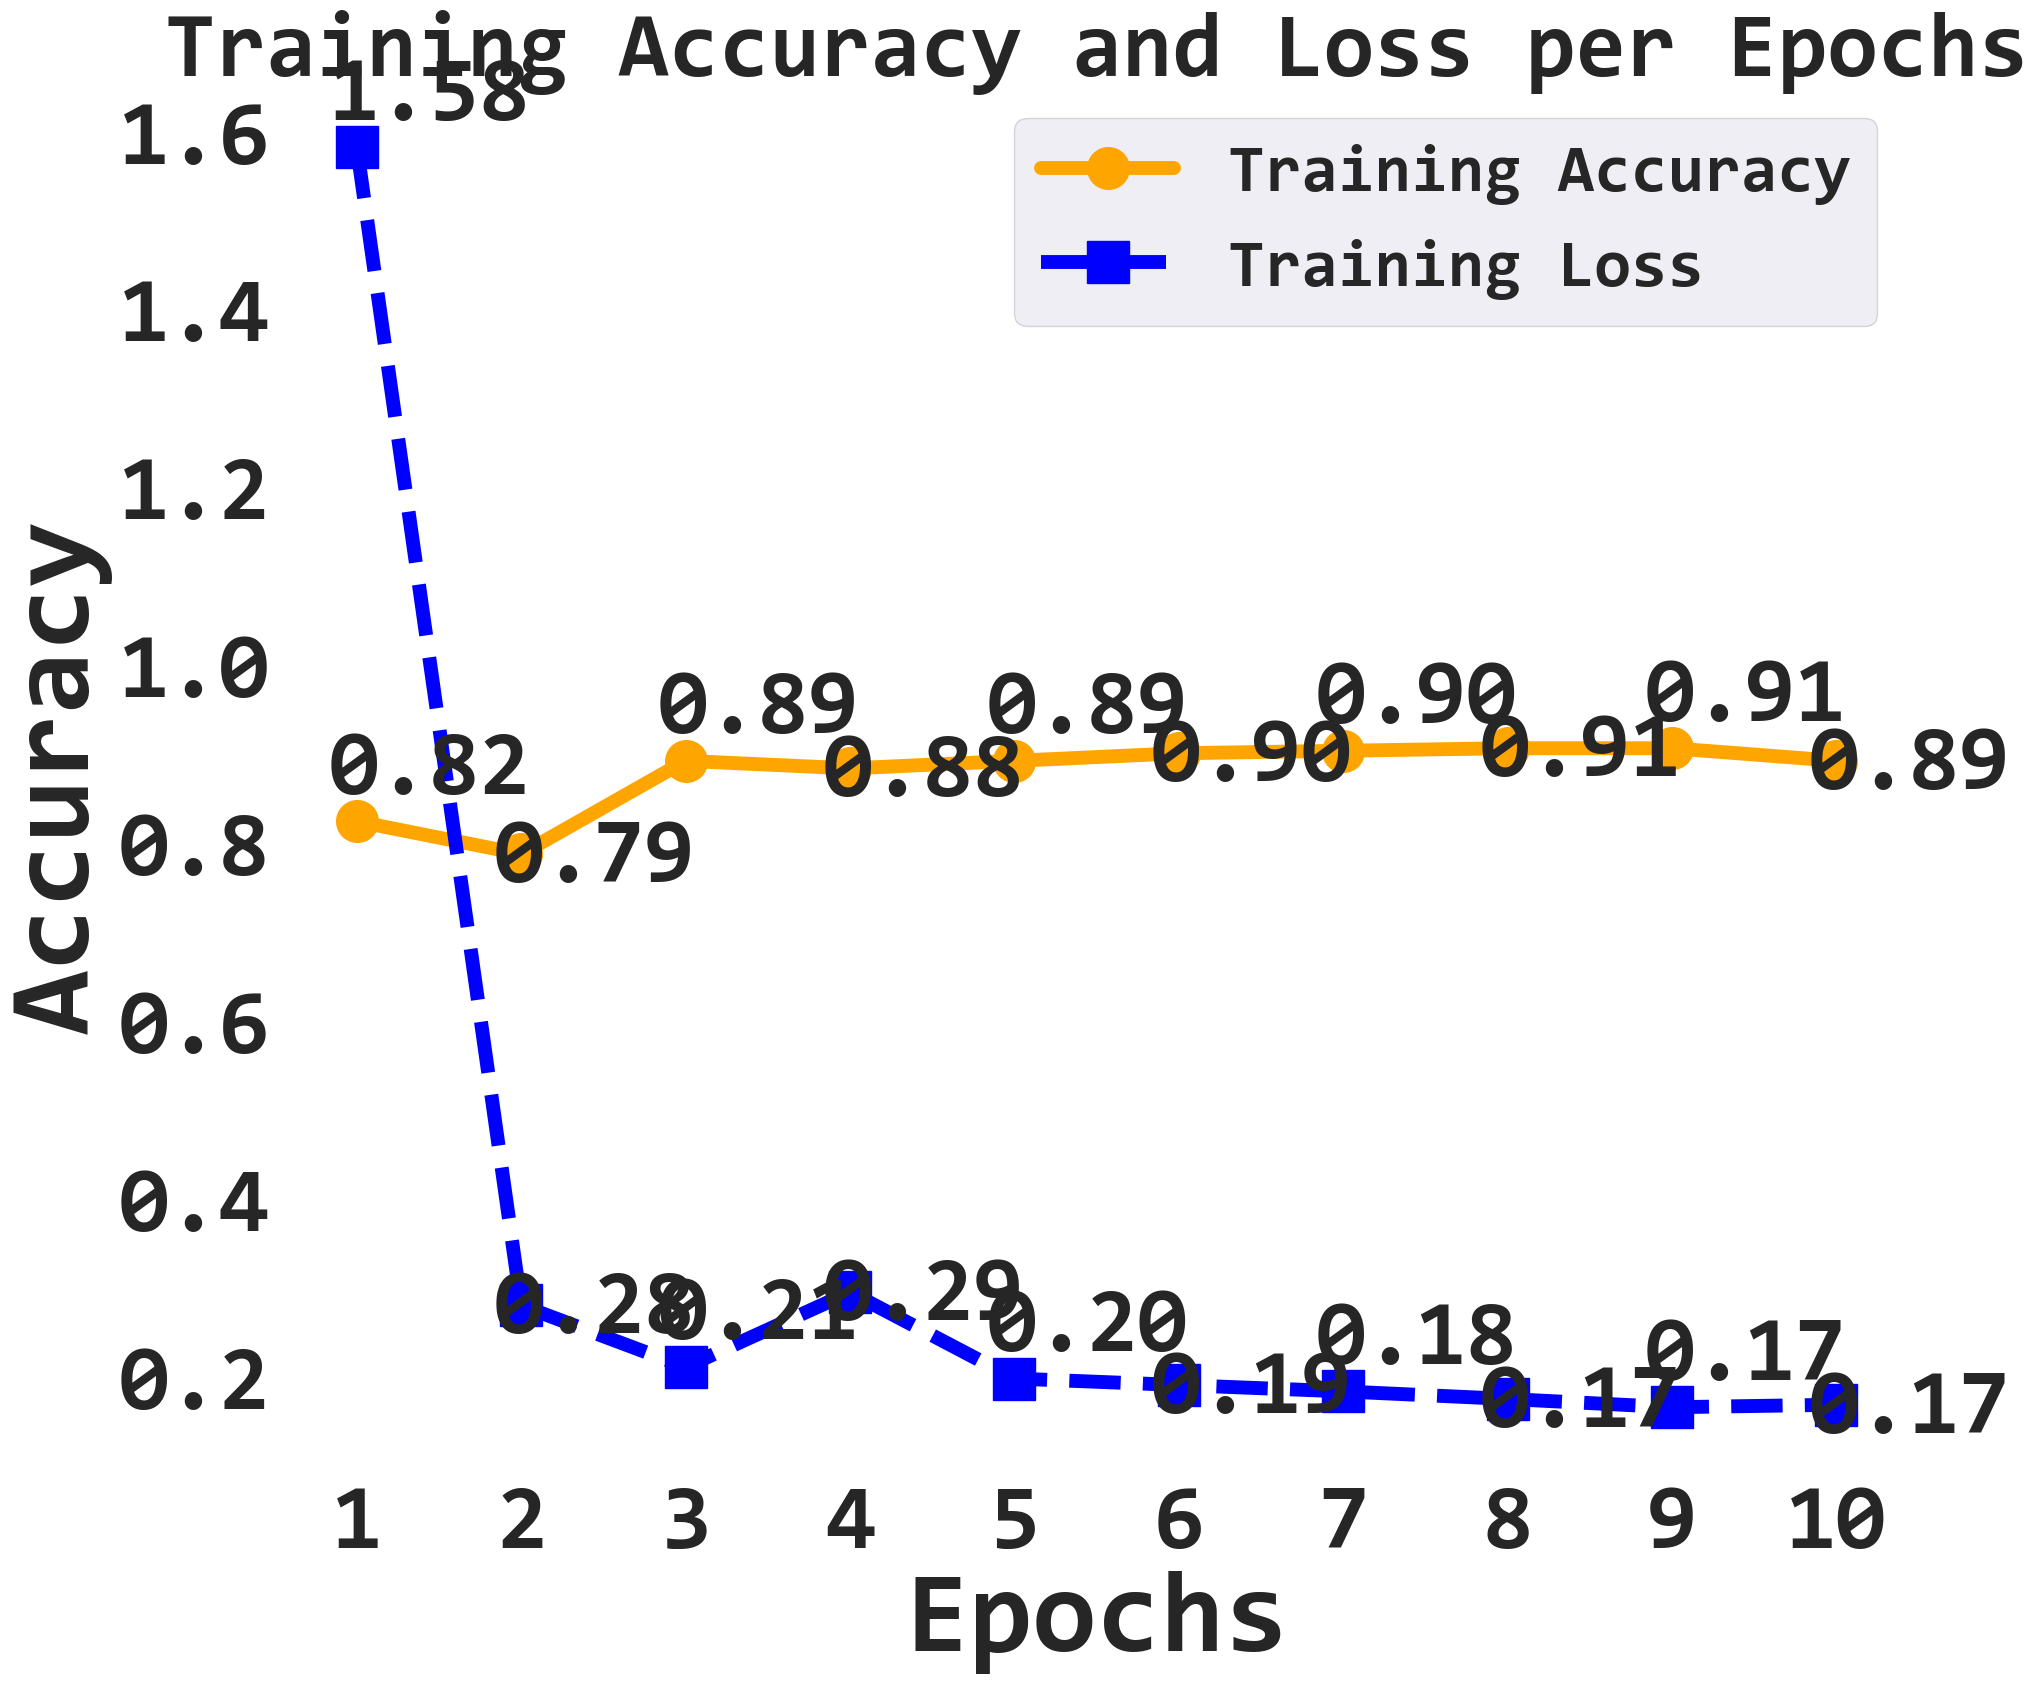

In [864]:
plt.figure(figsize=(21, 18), facecolor='white')  # Adjust the figure size

ax = plt.axes()
ax.set_facecolor('white')
# Plot training accuracy
plt.plot(epochs, history.history['accuracy'], marker='o', linestyle='-', linewidth=10, markersize=30,color = 'orange', label='Training Accuracy')
plt.plot(epochs, history.history['loss'], marker='s', linestyle='--', linewidth=10,  color='blue', markersize=30, label='Training Loss')

plt.xlabel('Epochs', fontsize=84, fontweight='bold')
plt.ylabel('Accuracy', fontsize = 84, fontweight='bold')
plt.title('Training Accuracy and Loss per Epochs', fontsize=66, fontweight='bold')
plt.grid(False)

plt.xticks(epochs, fontweight = 'bold', fontsize = 66)  # Set the x-axis ticks to match the epochs
plt.yticks(fontweight='bold', fontsize = 66)  # Use fontweight parameter to make the y-axis tick labels bold
# Add a horizontal line for maximum validation accuracy (optional)
max_val_accuracy = max(history.history['val_accuracy'])
legend_font = {'weight': 'bold', 'size': 48}  # Customize font size and weight
legend = plt.legend(prop=legend_font)  # Set the legend position and font properties

for i, acc in enumerate(history.history['accuracy']):
    offset_y = 20 if i % 2 == 0 else -20  # Use positive offset for even indices and negative offset for odd indices
    plt.annotate(f'{acc:.2f}', xy=(epochs[i], acc), xytext=(-20, offset_y), textcoords='offset points', fontweight='bold', fontsize=66)

# Annotate points on the loss curves with their corresponding values (optional)
for i, loss in enumerate(history.history['loss']):
    offset_y = 20 if i % 2 == 0 else -20  # Use positive offset for even indices and negative offset for odd indices
    plt.annotate(f'{loss:.2f}', xy=(epochs[i], loss), xytext=(-20, offset_y), textcoords='offset points', fontweight='bold', fontsize=66)

    
plt.savefig('T4TF5EMBD48NEW_train.png', dpi=600)  # Specify a higher DPI value (e.g., 300)
plt.show()

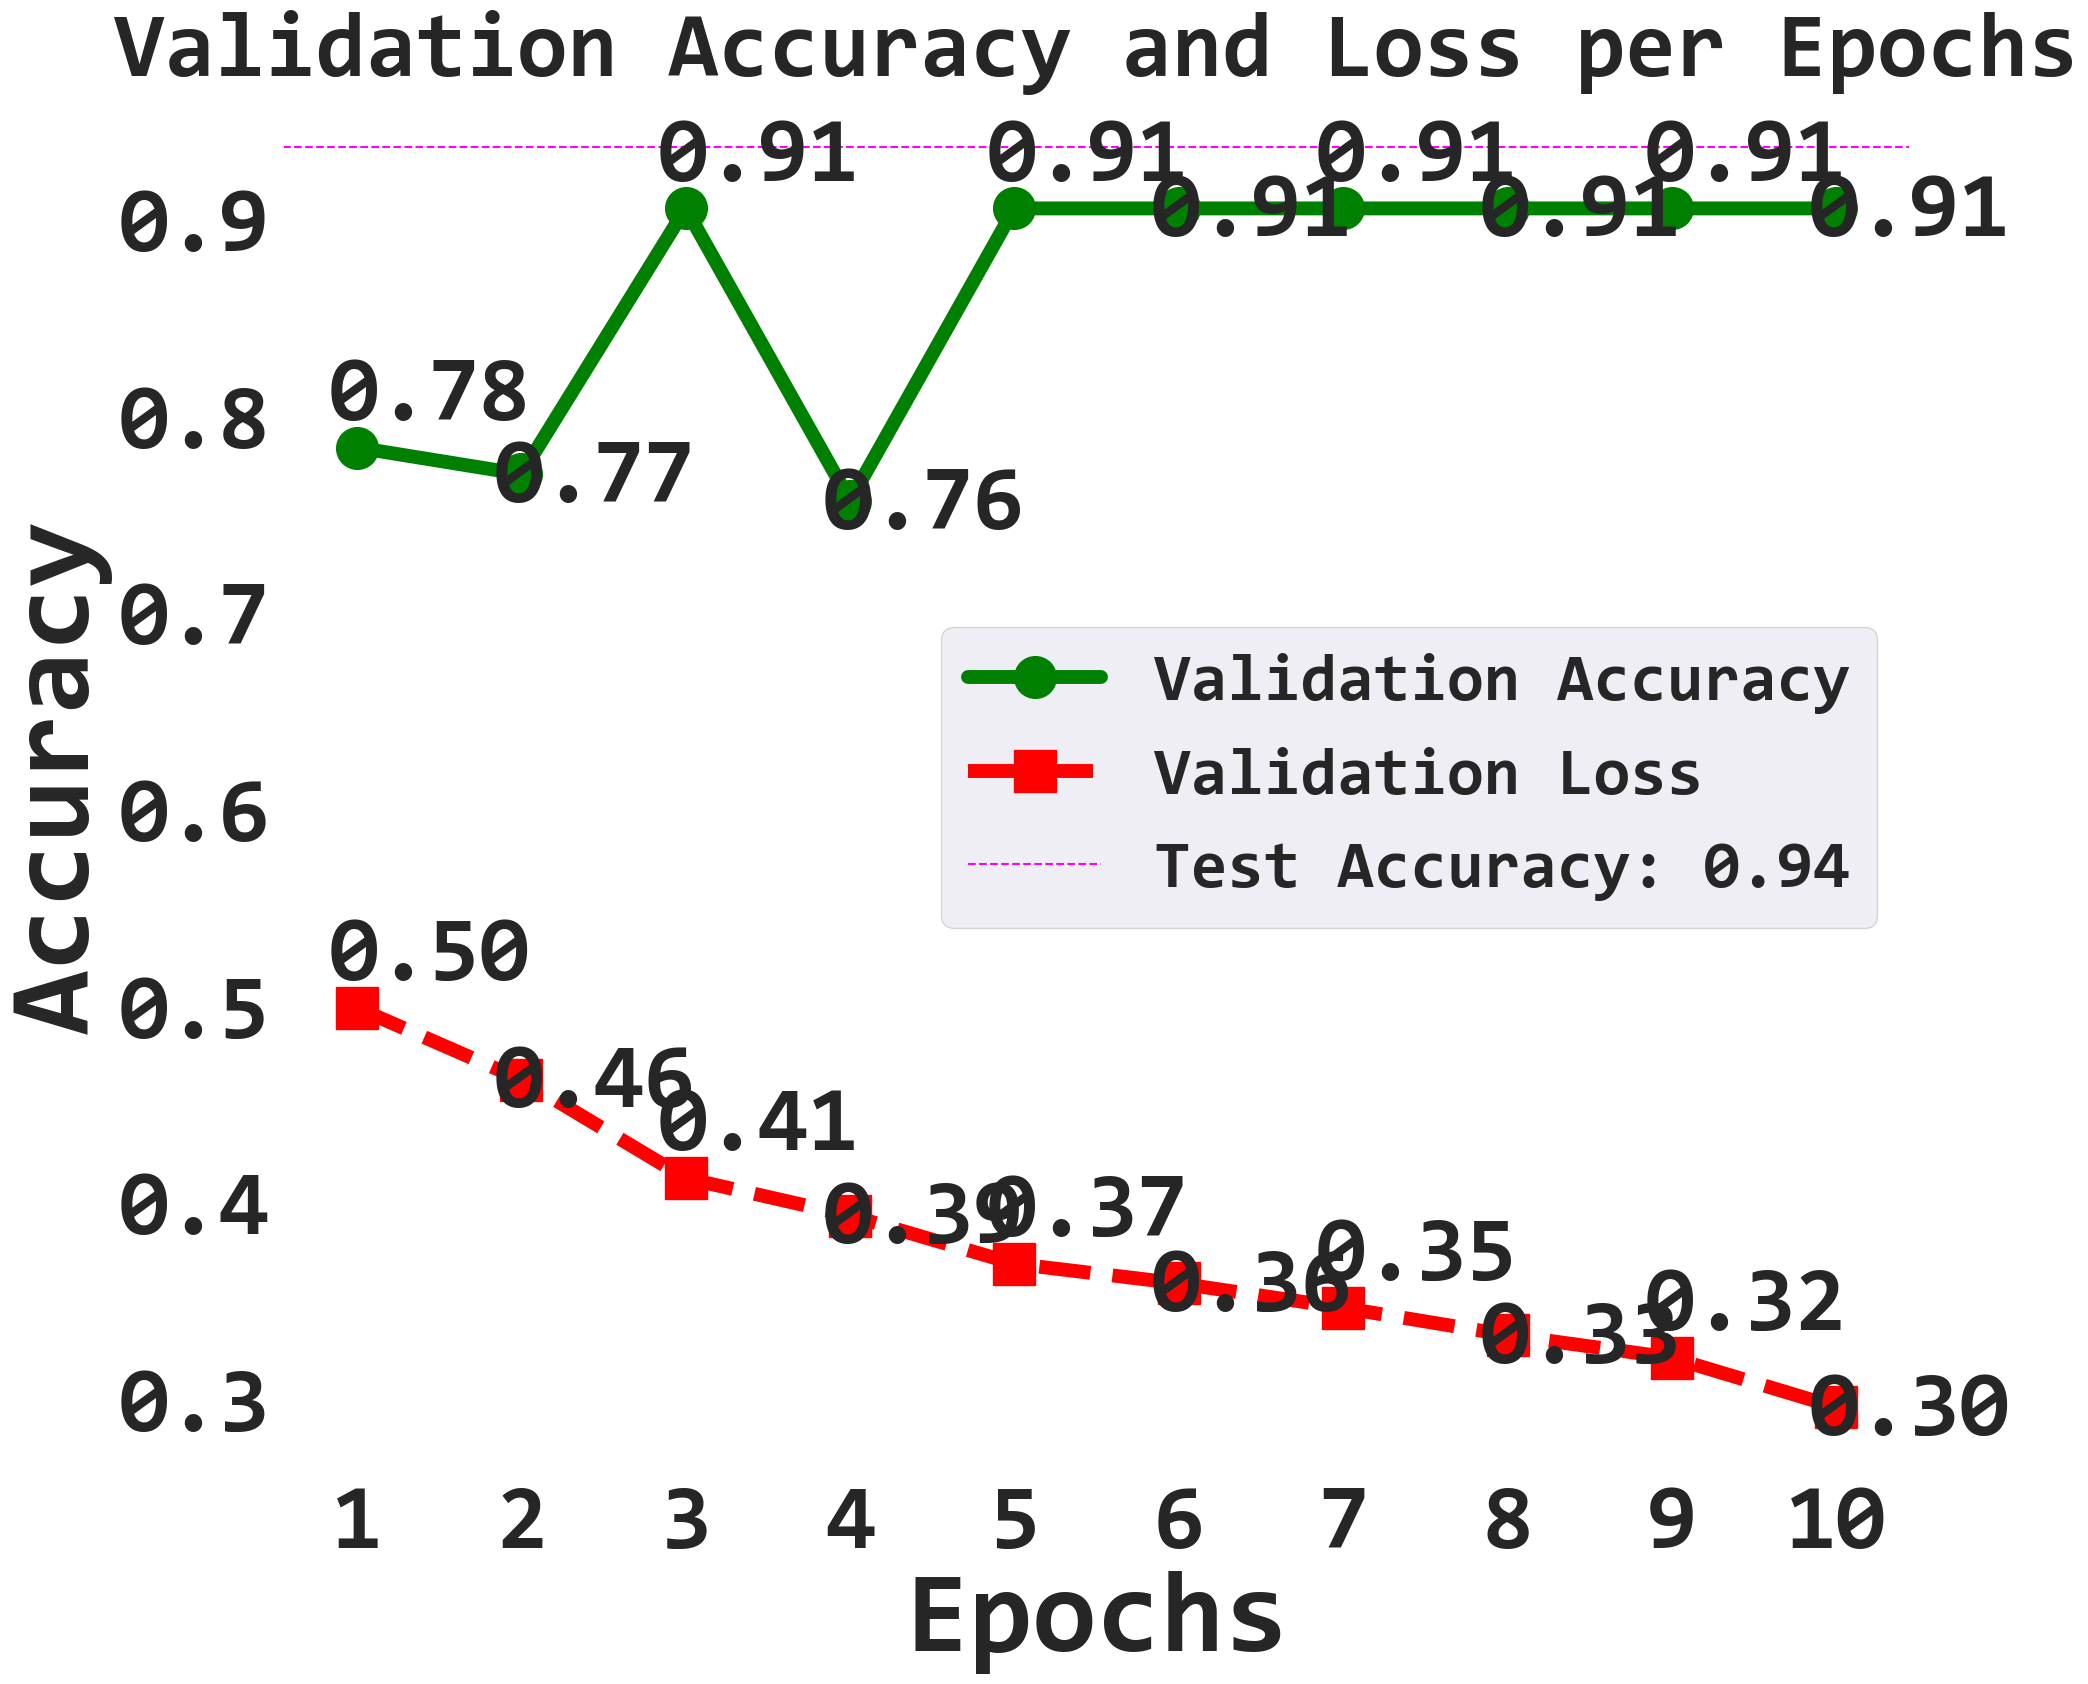

In [865]:
# Set the font size for the plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'Consolas'

# After plotting the data
# Create the plot
plt.figure(figsize=(21, 18), facecolor='white')  # Adjust the figure size
ax = plt.axes()
ax.set_facecolor('white')
plt.plot(epochs, history.history['val_accuracy'], marker='o', linestyle='-', linewidth=10, color='green', markersize=30, label='Validation Accuracy')
plt.plot(epochs, history.history['val_loss'], marker='s', linestyle='--', linewidth=10, color='red', markersize=30, label='Validation Loss')

plt.xlabel('Epochs', fontsize=84, fontweight='bold')
plt.ylabel('Accuracy', fontsize = 84, fontweight='bold')
plt.title('Validation Accuracy and Loss per Epochs', fontsize=66, fontweight='bold')
plt.grid(False)


plt.xticks(epochs, fontweight = 'bold', fontsize = 66)  # Set the x-axis ticks to match the epochs
plt.yticks(fontweight='bold', fontsize = 66)  # Use fontweight parameter to make the y-axis tick labels bold
# Add a horizontal line for maximum validation accuracy (optional)

max_val_accuracy = max(history.history['val_accuracy'])
# plt.axhline(y=max_val_accuracy, color='gray', linestyle='--', label=f'Max Val. Accuracy: {max_val_accuracy:.2f}')
plt.axhline(y=test_acc, color='magenta', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')
# plt.legend(prop={'weight': 'bold'}, fontsize = 36)
legend_font = {'weight': 'bold', 'size': 48}  # Customize font size and weight
legend = plt.legend(prop=legend_font)  # Set the legend position and font properties



for i, acc in enumerate(history.history['val_accuracy']):
    offset_y = 20 if i % 2 == 0 else -20  # Use positive offset for even indices and negative offset for odd indices
    plt.annotate(f'{acc:.2f}', xy=(epochs[i], acc), xytext=(-20, offset_y), textcoords='offset points', fontweight='bold', fontsize=66)

# Annotate points on the loss curves with their corresponding values (optional)
for i, loss in enumerate(history.history['val_loss']):
    offset_y = 20 if i % 2 == 0 else -20  # Use positive offset for even indices and negative offset for odd indices
    plt.annotate(f'{loss:.2f}', xy=(epochs[i], loss), xytext=(-20, offset_y), textcoords='offset points', fontweight='bold', fontsize=66)

    
plt.savefig('T4TF5EMBD48NEW_val.png', dpi=600)  # Specify a higher DPI value (e.g., 300)
plt.show()

In [93]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()